In [1]:
# Instala as bibliotecas necessárias
!pip install tensorflow scikit-learn numpy matplotlib

# Importa as bibliotecas
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# Pasta do colab com as imagens
# dataset
# - categoria 1
# -- imagens
# - categoria 2
# -- imagens
# - categoria 3
# -- imagens
# - categoria 4
# -- imagens
dataset_path = 'dataset'

# Verifique se o caminho existe
if not os.path.exists(dataset_path):
    print(f"Erro: O caminho do dataset '{dataset_path}' não foi encontrado.")
else:
    print(f"Dataset encontrado em: {dataset_path}")
    # Opcional: listar algumas pastas para confirmar
    print("Subpastas (classes) encontradas:")
    for item in os.listdir(dataset_path):
        if os.path.isdir(os.path.join(dataset_path, item)):
            print(f"- {item}")

Dataset encontrado em: dataset
Subpastas (classes) encontradas:
- .ipynb_checkpoints
- canecas
- relogios


In [3]:
# Carregando o modelo pré-treinado - ResNet50
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print("Modelo ResNet50 carregado com sucesso.")

# Função para extrair features de uma imagem
def extract_features(img_path, model):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)
        return features.flatten()
    except Exception as e:
        print(f"Erro ao processar a imagem {img_path}: {e}")
        return None

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo ResNet50 carregado com sucesso.


In [4]:
# Processar todas as imagens do seu dataset
all_image_paths = []
all_image_features = []

print("\nExtraindo features das imagens (isso pode levar um tempo, dependendo do número de imagens)...")
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(root, file)
            features = extract_features(img_path, model)
            if features is not None:
                all_image_paths.append(img_path)
                all_image_features.append(features)

all_image_features = np.array(all_image_features)
print(f"Features extraídas para {len(all_image_paths)} imagens.")


Extraindo features das imagens (isso pode levar um tempo, dependendo do número de imagens)...
Features extraídas para 360 imagens.


In [6]:
# Salvar as features e os caminhos para uso futuro
features_save_path = 'dataset/all_image_features.npy'
paths_save_path = 'dataset/all_image_paths.txt'

np.save(features_save_path, all_image_features)
with open(paths_save_path, 'w') as f:
    for item in all_image_paths:
        f.write("%s\n" % item)

print(f"Features salvas em: {features_save_path}")
print(f"Caminhos das imagens salvos em: {paths_save_path}")

Features salvas em: dataset/all_image_features.npy
Caminhos das imagens salvos em: dataset/all_image_paths.txt


In [7]:
# Função para encontrar produtos similares
def find_similar_products(query_image_path, model, all_image_paths, all_image_features, num_results=5):
    print(f"Processando imagem de consulta: {query_image_path}")
    query_features = extract_features(query_image_path, model)

    if query_features is None:
        print("Não foi possível extrair features da imagem de consulta.")
        return []

    # Calcular similaridade de cosseno entre a imagem de consulta e todas as outras
    similarities = cosine_similarity(query_features.reshape(1, -1), all_image_features)

    # Obter os índices das imagens mais similares
    similar_indices = similarities.flatten().argsort()[-num_results-1:][::-1]

    results = []
    for idx in similar_indices:
        # Evita recomendar a própria imagem de consulta se ela for parte do dataset
        if all_image_paths[idx] != query_image_path:
            results.append((all_image_paths[idx], similarities.flatten()[idx]))
        if len(results) >= num_results: # Garante que só pegamos o número desejado de resultados
            break

    return results

In [ ]:
# Fazer upload de uma imagem de consulta
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    query_product_image = f'/content/{filename}'
    print(f"Imagem de consulta carregada: {query_product_image}")

In [19]:
# Definindo a quantidade de resultados que eu espero
num_results_to_display = 3
similar_products = find_similar_products(query_product_image, model, all_image_paths, all_image_features, num_results=num_results_to_display)

Processando imagem de consulta: /content/parede.jpg



Buscando produtos similares para: /content/parede.jpg

Produtos Similares Encontrados:
  - Imagem: dataset/relogios/imagem_51.jpg | Similaridade: 0.6631
  - Imagem: dataset/relogios/imagem_48.jpg | Similaridade: 0.6201
  - Imagem: dataset/relogios/imagem_102.jpg | Similaridade: 0.5445


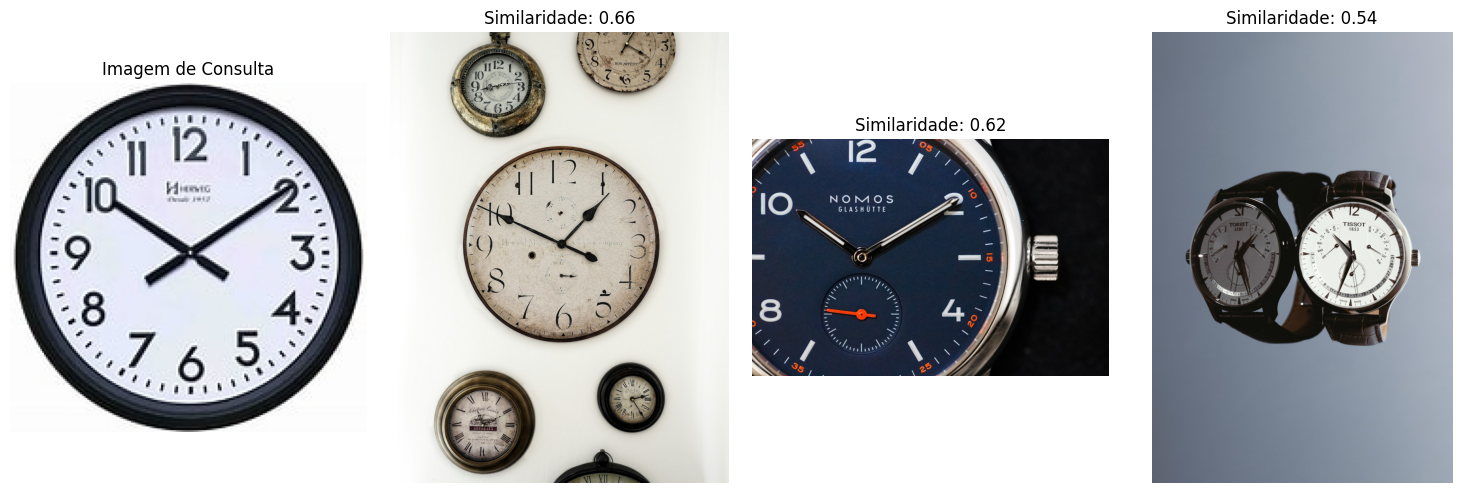

In [20]:
if os.path.exists(query_product_image):
    print(f"\nBuscando produtos similares para: {query_product_image}")

    if similar_products:
        print("\nProdutos Similares Encontrados:")
        plt.figure(figsize=(15, 5))

        # Exibe a imagem de consulta
        plt.subplot(1, num_results_to_display + 1, 1)
        query_img = image.load_img(query_product_image)
        plt.imshow(query_img)
        plt.title("Imagem de Consulta")
        plt.axis('off')

        # Exibe os resultados similares
        for i, (path, score) in enumerate(similar_products):
            print(f"  - Imagem: {path} | Similaridade: {score:.4f}")
            plt.subplot(1, num_results_to_display + 1, i + 2)
            img_result = image.load_img(path)
            plt.imshow(img_result)
            plt.title(f"Similaridade: {score:.2f}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhum produto similar encontrado ou erro ao processar a imagem de consulta.")
else:
    print(f"Erro: Imagem de consulta '{query_product_image}' não encontrada no caminho especificado.")
    print("Por favor, verifique o caminho ou faça upload da imagem.")